# Macro-Induced Lightning Constraints

In [1]:
"""
    TITLE   : Macro-Induced Lightning Constraints
    AUTHOR  : Jagjit Sidhu, Nathaniel Starkman
    PROJECT : https://github.com/nstarman/macro_lightning
""";

__author__ = ['Jagjit Sidhu', "Nathaniel Starkman"]

<span style='font-size:30px;font-weight:650'>
    About
</span>

This notebook contains the calculations for how well macro-induced lightnint on Earth and Jupiter can constrain macro models.


<br><br>

- - - 


## Prepare

### Imports

In [2]:
# BUILT-IN

import csv
import io
import itertools
import os
import sys


# THIRD PARTY

from astropy import units as u
from astropy.units import Quantity

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from numpy.linalg import norm

import scipy
from scipy.interpolate import interp1d

import utilipy

# PROJECT SPECIFIC

sys.path.insert(0, "../")
import src


set autoreload to 1


### Parameters

In [3]:
# velocities
v_unit = u.km / u.s

v1_ref = 42.1 * u.km / u.s
vy_ref = 200.0 * u.km / u.s
macro_vel = 250 * u.km / u.s

gc_v_ref = 550 * v_unit
gc_v_start = -500 * u.km / u.s
gc_v_stop = gc_v_ref
v_step = 50 * v_unit

vels = np.arange(
    gc_v_start.to_value(v_unit),
    (gc_v_stop + v_step).to_value(v_unit),
    v_step.to_value(v_unit)
)[::-1] * v_unit

ref_sigmax = 6e-8 * u.cm**2


In [4]:
PI = np.pi

### Functions

In [5]:
def as_quantity(a):
    """Convert argument to a Quantity (or raise NotImplementedError)."""
    try:
        return Quantity(a, copy=False, subok=True)
    except Exception:
        raise NotImplementedError
# /def

def qsquare(*args):
    return np.square(as_quantity(args))
# /def

def qnorm(*args):
    return np.linalg.norm(as_quantity(args))
# /def

### Data

In [6]:
micalines = src.data.load_mica_constraint()  # TODO get file

superbursts = src.data.load_superbursts_polygon()
superbursts1 = src.data.load_superbursts1_polygon()

humanmass = src.data.humanmass
humancross = src.data.humancross
humanupper = src.data.humanupper

DFNmass = src.data.DFNmass
DFNcrosssection = src.data.DFNcrosssection
DFNupper = src.data.DFNupper
DFNfuturemass = src.data.DFNfuturemass
DFNfuturecrosssection = src.data.DFNfuturecrosssection
DFNfutureupper = src.data.DFNfutureupper

WD = src.data.WD


array([[80000000000, 8e-08],
       [700000000000000, 0.007],
       [1000000000000000000, 140],
       [2e+20, 54000],
       [4e+21, 1000000],
       [4.8e+22, 12000000.0],
       [4.8e+22, 140],
       [7000000000000000000000, 0.007],
       [800000000000000000000, 8e-08],
       [80100000000.0, 8e-08]], dtype=object)

<br><br>

- - - 


## Code

In [9]:
Mhold=[]
Shold=[]

vbar=0.0
f=0.0
Vhold = 800.0 * u.km / u.s

for vx, vz, vy in itertools.product(vels, vels, vels):  # why this order?
    if qnorm(vx, vy, vz) > gc_v_ref:
        a=1

    else:
        vrel = qnorm(v1_ref, vx, vy-vy_ref, vz)

        const = np.power(v_step / macro_vel / np.sqrt(np.pi), 3)  # 3 dimensions
        factor = const * np.exp(-(qnorm(vx, vy, vz) / macro_vel)**2)
        vbar = vbar + vrel * factor  # problem? never reset vbar

        Mx = 3 * vbar.to_value(v_unit) * 1e3  # TODO units

        if Vhold < vrel:
            vrel = Vhold
        else:
            vrel = qnorm(v1_ref, vx, vy-vy_ref, vz)

        sigmax = 1e4 / (vrel.to_value(v_unit)*1e3)**2   # TODO internal units
        if sigmax < ref_sigmax.to_value():
            sigmax = ref_sigmax.to_value()

        Mhold.append(Mx)
        Shold.append(sigmax)

        Vhold = vrel    # problem? never reset Vhold
# /for

Mhold = np.array(Mhold)
Shold = np.array(Shold)

In [10]:
Mhold

array([1.99964200e+01, 3.94819707e+01, 6.19022690e+01, ...,
       9.85199571e+05, 9.85223375e+05, 9.85245292e+05])

In [25]:
M = []
S = []

for k, i in itertools.product(range(1,10), range(1,10)):
    sel = (i*10**k < Mhold) & (Mhold < (i+1)*10**k)
    if sum(sel) > 0:
        S.append(min(Shold[sel]))
        M.append((2*i+1) * 10**k / 2)

np.array(S)

array([6.00000000e-08, 6.00000000e-08, 6.00000000e-08, 6.00000000e-08,
       6.00000000e-08, 6.00000000e-08, 6.00000000e-08, 6.00000000e-08,
       6.00000000e-08, 6.00000000e-08, 6.00000000e-08, 6.00000000e-08,
       6.00000000e-08, 6.00000000e-08, 6.00000000e-08, 6.00000000e-08,
       6.00000000e-08, 6.00000000e-08, 6.00000000e-08, 6.00000000e-08,
       6.00000000e-08, 6.00000000e-08, 6.00000000e-08, 6.18152378e-08,
       8.04683839e-08, 8.04683839e-08, 9.82584573e-08, 1.08965211e-07,
       1.08965211e-07, 1.08965211e-07, 1.49762454e-07, 1.55587755e-07,
       2.39392460e-07, 7.00652518e-07, 2.34059933e-06, 5.64203542e-06,
       5.64203542e-06, 5.64203542e-06, 5.64203542e-06, 5.64203542e-06])

In [30]:
lightning = np.c_[M, S]  # Not used?

In [59]:
lightning = np.array([
    [25000.0, 6.18152378393819e-08], 
    [35000.0, 8.046838393171901e-08],
    [55000.0, 9.825845727737015e-08], 
    [75000.0, 1.0896521078611754e-07],  
    [95000.0, 1.4976245428313878e-07],
    [150000.0, 1.555877553058925e-07],
    [250000.0, 2.3939246023870776e-07], 
    [350000.0, 7.006525176897245e-07],
    [450000.0, 2.3405993338654298e-06],  
    [950000.0, 5.6420354206983716e-06]
])

z = np.polyfit(lightning[:, 0], lightning[:, 1], 8)
p = np.poly1d(z)

sigmalightning=[]
# for j in range(len(lightning)):
for x, y in lightning:
    test = (
        z[8]
        + z[7]*x
        + z[6]*x**2
        + z[5]*x**3
        + z[4]*x**4
        + z[3]*x**5
        + z[2]*x**6
        + z[1]*x**7
        + z[0]*x**8
    )
    sigmalightning.append(test)
    delta = ((test - y) / y) * 100

masslightning = []
upperlightning = []

for x in lightning[:, 0]:
    masslightning.append(x)
    upperlightning.append(x * 10**-4)

masslightning.insert(0,6*10**-4)
sigmalightning.insert(0, 6*10**-8)
upperlightning.insert(0, 6*10**-8)

masslightning = np.array(masslightning)
upperlightning = np.array(upperlightning)
sigmalightning = np.array(sigmalightning)

print(masslightning, upperlightning, sigmalightning, sep="\n")

[6.0e-04 2.5e+04 3.5e+04 5.5e+04 7.5e+04 9.5e+04 1.5e+05 2.5e+05 3.5e+05
 4.5e+05 9.5e+05]
[6.0e-08 2.5e+00 3.5e+00 5.5e+00 7.5e+00 9.5e+00 1.5e+01 2.5e+01 3.5e+01
 4.5e+01 9.5e+01]
[6.00000000e-08 6.06917228e-08 8.34545741e-08 9.36872264e-08
 1.13439391e-07 1.47850373e-07 1.55744531e-07 2.39380626e-07
 7.00654185e-07 2.34059918e-06 5.64203542e-06]


In [61]:
jupitermasslightning = masslightning[:] * 2000.0
uppersigmalightningjupiter = jupitermasslightning[:] * 10**-4

print(jupitermasslightning, uppersigmalightningjupiter, sep="\n")

[1.2e+00 5.0e+07 7.0e+07 1.1e+08 1.5e+08 1.9e+08 3.0e+08 5.0e+08 7.0e+08
 9.0e+08 1.9e+09]
[1.2e-04 5.0e+03 7.0e+03 1.1e+04 1.5e+04 1.9e+04 3.0e+04 5.0e+04 7.0e+04
 9.0e+04 1.9e+05]


In [72]:
# Mhold=[]
# Shold=[]

# vbar=0.0
# f=0.0
# Vhold=800.0 * u.km / u.s

# for vx, vz, vy in itertools.product(vels, vels, vels):  # why this order?
#     if qnorm(vx, vy, vz) > gc_v_ref:
#         a = 1

#     else:
#         vrel = qnorm(v1_ref, vx, vy-vy_ref, vz)

#         const = np.power(v_step / macro_vel / np.sqrt(np.pi), 3)  # 3 dimensions
#         factor = const * np.exp(-(qnorm(vx, vy, vz) / macro_vel)**2)
#         vbar = vbar + vrel * factor  # problem? never reset vbar

#         Mx = 1e5*vbar.to_value(v_unit)*1000/3  # TODO units

#         if Vhold<vrel:
#             vrel = Vhold
#         else:
#             vrel = qnorm(v1_ref, vx, vy-vy_ref, vz)
        
#         const = np.power(v_step / macro_vel / np.sqrt(np.pi), 3)  # 3 dimensions
#         factor = const * np.exp(-(qnorm(vx, vy, vz) / macro_vel)**2)
#         f = f + vrel * factor  # problem? never used
        
#         sigmax=(1e-10*(250/vrel.to_value(v_unit))**7)**(1/3)   # TODO internal units

#         Mhold.append(Mx)
#         Shold.append(sigmax)
#         Vhold=vrel
# # /for

# Mhold = np.array(Mhold)
# Shold = np.array(Shold)
# Mhold

<Quantity [ 550.,  500.,  450.,  400.,  350.,  300.,  250.,  200.,  150.,
            100.,   50.,    0.,  -50., -100., -150., -200., -250., -300.,
           -350., -400., -450., -500.] km / s>

array([2.22182445e+05, 4.38688564e+05, 6.87802989e+05, ...,
       1.09466619e+10, 1.09469264e+10, 1.09471699e+10])

In [75]:
Mhold=[]
Shold=[]

vbar=0.0
f=0.0
Vhold = 800.0

for i in range(0,22):
    vx=550.0-i*50.0
    for j in range(0,22):
        vz=550.0-j*50.0
        for k in range(0,22):
            vy=550.0-k*50.0  #this is in the Galactic rest frame
            
            if (np.sqrt(vx**2+vy**2+vz**2)>550.0):
                pass

            elif(np.sqrt(42.1**2+vx**2+vz**2+(vy-200.0)**2)>250.0):
                vrel=np.sqrt(42.1**2+vx**2+vz**2+(vy-200.0)**2)
                vbar=vbar+(vrel)*np.exp(-(vx**2+vy**2+vz**2)/(250.0**2))*(50.0**3)/(np.pi*250.0**2)**1.5
                Mx=10**5*vbar*1000/3

                if Vhold<vrel:
                    vrel=Vhold
                else:
                    vrel=np.sqrt(42.1**2+vx**2+vz**2+(vy-200.0)**2)

                f=f+np.exp(-(vx**2+vy**2+vz**2)/(250.0**2))*(50.0**3)/(np.pi*250.0**2)**1.5

                sigmax=(10**-10*(250/vrel)**7)**(1/3)

                Mhold.append(Mx)
                Shold.append(sigmax)
                Vhold=vrel
                
Mhold = np.array(Mhold)
Shold = np.array(Shold)
Mhold

array([2.22182445e+05, 4.38688564e+05, 6.87802989e+05, ...,
       9.34974331e+09, 9.35000781e+09, 9.35025133e+09])

In [83]:
M = []
S = []

for k, i in itertools.product(range(5,15), range(1,9)):
    sel = (i*10**k < Mhold) & (Mhold < (i+1)*10**k)
    if sum(sel) > 0:
        S.append(min(Shold[sel]))
        M.append((2*i+1) * 10**k / 2)

np.array(S)

array([6.34075195e-05, 7.39435960e-05, 7.39435960e-05, 7.39435960e-05,
       8.17931170e-05, 8.17931170e-05, 8.72868532e-05, 8.72868532e-05,
       8.72868532e-05, 9.02978842e-05, 9.02978842e-05, 9.13448065e-05,
       9.13448065e-05, 9.46251397e-05, 1.10255278e-04, 1.14934920e-04,
       1.16577666e-04, 1.16577666e-04, 1.16577666e-04, 1.18264557e-04,
       1.53039953e-04, 2.03390727e-04, 2.08172255e-04, 2.08172255e-04,
       2.87350071e-04, 2.96503070e-04, 2.96503070e-04, 4.29698127e-04,
       4.49260261e-04, 4.49260261e-04, 4.49260261e-04, 4.49260261e-04,
       4.49260261e-04, 4.49260261e-04, 4.49260261e-04])

In [93]:
jovian = np.c_[
    M + [8.5*1e9, 0.634, 250000.0],
    S + [8.5*1e9*1e-4, 6.34075194929149e-05, 6.34075194929149e-05]
]

NameError: name 'micalines' is not defined

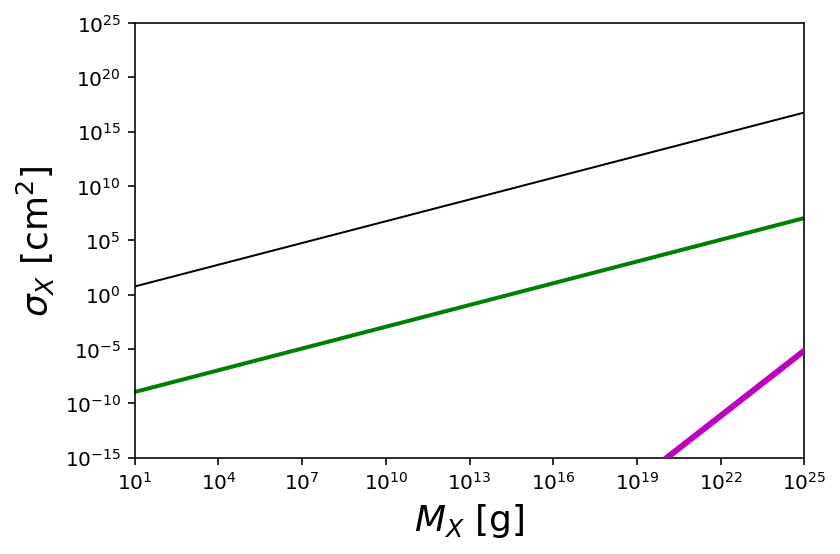

In [95]:
def CMB(M):
    f = 4.5e-7 * M
    return f

#Nuclear Density
def nuc(M):
    f = PI*(3/(4*PI*3.6e14))**(2./3) *pow(M,2./3)
    return f

#Black Holes
def BH(M):
    f = PI*(3e5)**2 *(M/(2e33))**2
    return f

#Atomic Density
def atom(M):
    f = PI*(3/(4*PI*1*10**0))**(2./3) *pow(M,2./3)
    return f

def KeplerTop(M):
    f = 1e-6*M
    return f

def LMCTop(M):
    f = 1e-4*M
    return f

M1=np.logspace(1,25)
MMica = np.logspace(-10, 2.204)# for M_max=160g
MMica1 = np.logspace(-12,1.43,num=1000)#  2.204 for M_max=160g  1.74 for M_max = 55g  1.43 for M_max=27.5g
MMica2 = np.logspace(1.43,1.74,num=1000)
Mmicro = np.logspace(23.0,28.0)

#Define Plot
fig = plt.figure()
ax = fig.add_subplot(111)

#X-axis
ax.set_xlabel('$M_\t{X}$ [g]',fontsize=18)
ax.set_xlim([M1.min(),M1.max()])

#Y-axis
ymin=10**-15#nuc(M1).min()#10**(-15)
ymax=float(10**25)#nuc(M1).max()#10**15
ax.set_ylim([ymin,ymax])
ax.set_ylabel('$\sigma_\t{X}$ [cm$^{2}$]',fontsize=18)

#Make Plot
ax.loglog(M1, atom(M1), 'k', markersize=4, color='k',lw=1,label='Atomic density',zorder=0)
ax.loglog(M1, nuc(M1), 'k', markersize=4, color='g',lw=2,label='Nuclear density',zorder=0)
ax.loglog(M1, BH(M1), 'k', markersize=4, color='m',lw=3,label='Black holes',zorder=3)

#commenting out lines below here will remove some exclusion regions
#each pair of lines is one constraint

line3 = plt.Polygon(micalines, closed=None, fill=True, facecolor='yellow', edgecolor='black',alpha=0.8, hatch="|",lw=1,zorder=0)# edgecolor='r'
plt.gca().add_line(line3) #e.g. only need to comment out this line (plt.gca()...)to remove mica constraints,
#but you can comment out both the above lines if you want

lineWD = plt.Polygon(WD, closed=None, fill=True, facecolor='blue', edgecolor='black',alpha=0.6, hatch="",lw=1,zorder=2)# edgecolor='r'
plt.gca().add_line(lineWD)

plt.fill_between(M1, CMB(M1),ymax,where=None, color='grey',edgecolor='black',hatch="",alpha=.7,zorder=1)#SIDM ,alpha=.5

linen = plt.Polygon(superbursts, closed=None, fill=True, facecolor='purple', edgecolor='black',alpha=0.6, hatch="",lw=1,zorder=5)# edgecolor='r'
plt.gca().add_line(linen)

# linelightning = plt.Polygon(lightning, closed=None, fill=True, facecolor='cyan', edgecolor='black',alpha=1, hatch="",lw=1,zorder=4)# edgecolor='r'
# plt.gca().add_line(linelightning)

# linejovian = plt.Polygon(jovian, closed=None, fill=True, facecolor='none', edgecolor='black',alpha=1, hatch="+",lw=1,zorder=3)# edgecolor='r'
# plt.gca().add_line(linejovian)

linen1 = plt.Polygon(superburst1, closed=None, fill=True, facecolor='purple', edgecolor='black',alpha=0.6, hatch="//",lw=1,zorder=5)# edgecolor='r'
plt.gca().add_line(linen1)

plt.fill_between(masslightning,sigmalightning ,upperlightning,where=None, facecolor='none',edgecolor='black',hatch="//",alpha=1.0,zorder=8)

plt.fill_between(jupitermasslightning,sigmalightning ,uppersigmalightningjupiter,where=None, facecolor='none',edgecolor='cyan',hatch="//",alpha=1.0,zorder=4)


# plt.fill_between(humanmass,humancross ,humanupper,where=None, facecolor='red',edgecolor='black',hatch="",alpha=1.0,zorder=5)
plt.fill_between(humanmass,humancross ,humanupper,where=None, facecolor='red',edgecolor='black',hatch="",alpha=1.0,zorder=5)
plt.fill_between(DFNmass,DFNcrosssection ,DFNupper,where=None, facecolor='green',edgecolor='black',hatch="",alpha=1.0,zorder=6)

# comment out lines below to remove lensing constraints, each line is a constraint itself
#unlike the above lines
plt.fill_between(Mmicro, BH(Mmicro), LMCTop(Mmicro), where=None,facecolor='brown', edgecolor='black', hatch="/",alpha=1,zorder=2) #BH ,label='BH',


plt.fill_between(M1, ymin, BH(M1), where=None,color='1', edgecolor='', hatch="+",alpha=1,zorder=2) #BH ,label='BH',

leghumans = Rectangle((0, 0), 1, 1, fc='purple',edgecolor='black', hatch="",alpha=0.6)
legbol = Rectangle((0, 0), 1, 1, fc="purple",edgecolor='black', hatch="/",alpha=0.6)
legbol2 = Rectangle((0, 0), 1, 1, fc='none',edgecolor='green', hatch="+",alpha=0.6)
legfluo = Rectangle((0, 0), 1, 1, fc="none",edgecolor='blue', hatch="//",alpha=1)
leggranite= Rectangle((0, 0), 1, 1, fc="none",edgecolor='purple', alpha=1,hatch="\ ")

leg = ax.legend(loc='upper left', shadow=True)
ax.grid(True)
plt.tight_layout()
plt.savefig('lightningconstraints.pdf')

plt.show();

<br><br>

- - - 

<span style='font-size:40px;font-weight:650'>
    END
</span>